In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Prepare Dataset
# load data

# relative path to npz files
path = 'Measurements/manual single top deformed at 20Hz'
file_name = 'output_batch_%d.npz'

def load_file(path, batch_id):
    """
    Loads in the memory a specific batch located in the given path.

    Returns a numpy NpzFile object with the image frames np array named
    as "frames" and the force measurements named as "frames".
    """
    combined_path = os.path.join(path,file_name %i)
    data = np.load(combined_path)
    return data

In [3]:
# Get dataset statistics for normalization
file_size = 1000 # one file contains 1000 samples
files_num = 2 # how many files to load
batch_size = 100 # should be something that leaves zero reminder when it divides the file_size
data_frames = []
data_forces = []
for i in range(files_num):
    data = load_file(path, i)
    data_frames.append(data['frames'])
    data_forces.append(data['forces'])
combined_frames = np.concatenate(data_frames, axis=0)
combined_forces = np.concatenate(data_forces, axis=0)
features_train = combined_frames
targets_train = combined_forces[:,2]
frames_mean = np.mean(features_train)
frames_std = np.std(features_train)
forces_z_mean = np.mean(targets_train)
forces_z_std = np.std(targets_train)
print(frames_mean)
print(frames_std)
print(forces_z_mean)
print(forces_z_std)

175.93011425797326
83.80256105196054
-0.986235911609605
1.4660020523737218


In [4]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_channels, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 9, kernel_size = 5, stride = 1, padding = 2)
        self.pool = nn.MaxPool2d(kernel_size = 4, stride = 4)
        self.conv2 = nn.Conv2d(9, 18, kernel_size = 5, stride = 1, padding = 2)
        
        # RNN
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(18 * 16 * 30, hidden_dim, layer_dim, batch_first=True, dropout = 0.2, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool(nn.ELU()(self.conv1(x)))
        x = self.pool(nn.ELU()(self.conv2(x)))
        
        # Reshape for RNN
        # x = torch.reshape(x, (100, 10, 18 * 16 * 30))
        x = torch.reshape(x, (1, 100, 18 * 16 * 30))  # Reshape to (batch_size, seq_len, input_size)
        #print("Size of x:", x.size())  # Print size of x
        
        # RNN
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        #print("Size of h0:", h0.size())  # Print size of h0 - Debugging - Obsolete
        out, hn = self.rnn(x, h0)
        
        # Output layer
        out = self.fc(out) 
        # out = torch.reshape(out, (1000, 1))
        out = torch.reshape(out, (100, 1)) # go back to compare to labels
        return out

In [5]:
# Create RNN
input_channels = 3  # RGB channels
hidden_dim = 200  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 1   # output dimension

model = RNNModel(input_channels, hidden_dim, layer_dim, output_dim)

# Define your loss function
error = nn.MSELoss()

# Define your optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Training

file_size = 1000 # one file contains 1000 samples
num_epochs = 30
files_num = 2 # how many files to load
seq_dim = 25
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
batch_size = 100 # should be something that leaves zero reminder when it divides the file_size
last_iter = -files_num * file_size/batch_size
for epoch in range(num_epochs):
    for i in range(files_num):
        data = load_file(path, i)
        
        for i in range(int(file_size/batch_size)):
            # Normalize
            normalized_frames = (data['frames'][i*batch_size:(i+1)*batch_size,:,:,:]-frames_mean)/frames_std
            normalized_forces = (data['forces'][i*batch_size:(i+1)*batch_size,2]-forces_z_mean)/forces_z_std

            # Create tensors
            images = torch.from_numpy(normalized_frames).float()
            labels = torch.from_numpy(normalized_forces).float()
                    
            # print(images.shape)  # Add this line to check the shape of images - Debugging purposes
            images = images.permute(0, 3, 1, 2)
                
            # Clear gradients
            optimizer.zero_grad()
            
            # Forward propagation
            outputs = model(images)
            outputs = torch.squeeze(outputs)
            
            # Calculate loss
            loss = error(outputs, labels)
            
            # Backpropagation
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            count += 1
                
            # Store loss and iteration
            loss_rescaled = loss.data.item() * pow(forces_z_std, 2)
            loss_list.append(loss_rescaled)
    # Print Loss
    print('Epoch: {}, MSE Loss: {}'.format((epoch+1), np.mean(loss_list[int(last_iter):])))

Epoch: 1, MSE Loss: 2.021439845233728
Epoch: 2, MSE Loss: 1.4987565466142523
Epoch: 3, MSE Loss: 0.829530417833935
Epoch: 4, MSE Loss: 0.5428821471362245
Epoch: 5, MSE Loss: 0.43354423423502036
Epoch: 6, MSE Loss: 0.3539868677950348
Epoch: 7, MSE Loss: 0.26928862503196993
Epoch: 8, MSE Loss: 0.23008465462900088
Epoch: 9, MSE Loss: 0.17211446330746427
Epoch: 10, MSE Loss: 0.16293804866549857
Epoch: 11, MSE Loss: 0.13926972969568646
Epoch: 12, MSE Loss: 0.12789012769353084
Epoch: 13, MSE Loss: 0.1133799965315954
Epoch: 14, MSE Loss: 0.10769272910909397
Epoch: 15, MSE Loss: 0.10057119160572821
Epoch: 16, MSE Loss: 0.09514504710492305
Epoch: 17, MSE Loss: 0.09781910718911047
Epoch: 18, MSE Loss: 0.0815387655965885
Epoch: 19, MSE Loss: 0.07310795692918569
Epoch: 20, MSE Loss: 0.07804021723538357
Epoch: 21, MSE Loss: 0.07291559200345404
Epoch: 22, MSE Loss: 0.0695847716279747
Epoch: 23, MSE Loss: 0.06433354352662493
Epoch: 24, MSE Loss: 0.057559102285094796
Epoch: 25, MSE Loss: 0.05562362038

[3.505042768956722, 2.0977447116618473, 2.1121603214080973, 2.1748647779132466, 1.4365020478997637, 1.1714192577783367, 1.0249873990797025, 2.6217822422571184, 2.28245138875019, 2.0920817932544997, 1.8790309330204964, 2.071832892049535, 1.764966047030378, 1.8245743256020417, 1.801880122759828, 2.29790512120943, 1.7791848951173053, 1.4191884309797758, 2.4647582397149943, 2.606439188231248, 2.9311750919378556, 1.3473259746135255, 1.6636782431925004, 1.5998682833540465, 1.309094005686736, 1.0649780534367286, 0.8692128843142939, 1.7684707359870282, 1.6463943454814727, 1.6194841141681429, 1.425765343162689, 1.5573584136374865, 1.2624048722101444, 1.2051856593587749, 1.3346210127830291, 1.5767512222843427, 1.298155671488871, 0.9687906166865917, 1.775727346974868, 1.7506890415259166, 2.002330935094966, 0.8709879665494742, 0.9537473167510955, 0.8653857035104138, 0.8678342076486282, 0.5864614480158388, 0.35975265773902293, 1.1003213024425804, 0.9206829033823039, 0.7900376450932681, 0.6778175918

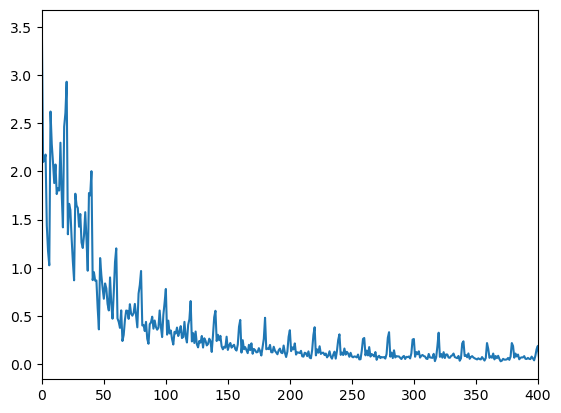

In [7]:
print(loss_list)
print(np.sqrt(np.mean(loss_list[-20:])))
plt.plot(range(len(loss_list)), loss_list)
plt.xlim((0,400))
plt.show()

In [8]:
print(outputs * forces_z_std + forces_z_mean) # Small sanity check

tensor([-2.6022e+00, -1.7915e+00, -7.7736e-01, -8.2668e-01, -6.1445e-01,
        -5.9100e-01, -4.1563e-01, -3.5638e-01, -2.2923e-01, -2.2574e-01,
        -1.0522e-01, -2.0670e-02, -1.1391e-01, -2.3097e-01, -2.7947e-01,
        -2.9871e-01, -1.4757e-01, -2.1437e-02, -1.4545e-01, -2.0262e-01,
        -3.3489e-01, -2.1193e-01, -1.2863e-01, -3.8002e-01, -1.1398e-01,
        -1.8697e-01, -1.1869e-01, -2.4394e-01, -3.1228e-01, -1.7572e-01,
        -8.6962e-01, -1.5735e+00, -2.4328e+00, -3.2495e+00, -3.3429e+00,
        -3.6197e+00, -4.1426e+00, -4.6709e+00, -5.0675e+00, -5.3237e+00,
        -4.9761e+00, -5.4205e+00, -4.0730e+00, -4.2967e+00, -3.9038e+00,
        -2.1837e+00,  3.8221e-02,  1.2691e-01, -1.9836e-01, -1.0149e-01,
        -6.4466e-02, -2.4202e-01, -2.7633e-01, -1.0555e-01, -1.9566e-01,
        -3.0611e-01, -2.0701e-01, -3.1155e-01, -1.3677e-01, -4.0522e-02,
        -1.5494e-01, -9.2019e-02, -2.7966e-01, -6.5264e-02, -9.2725e-02,
        -1.1845e-01, -1.2214e-01, -1.0419e-01, -2.7

In [9]:
print(labels.float() * forces_z_std + forces_z_mean)

tensor([-0.9837, -0.1637, -0.1279, -0.1309, -0.1346, -0.1297, -0.1344, -0.1294,
        -0.1343, -0.1282, -0.1322, -0.1240, -0.1298, -0.1313, -0.1317, -0.1270,
        -0.1292, -0.1361, -0.1341, -0.1336, -0.1390, -0.1233, -0.1278, -0.1282,
        -0.1346, -0.1320, -0.1334, -0.1283, -0.1324, -0.3513, -1.0552, -1.5855,
        -2.5075, -2.8629, -3.2809, -3.5987, -4.0110, -4.4015, -4.5454, -4.9288,
        -5.1063, -5.1722, -4.9448, -4.5689, -3.3009, -1.5864, -0.2401, -0.1187,
        -0.1239, -0.1288, -0.1313, -0.1257, -0.1342, -0.1297, -0.1307, -0.1230,
        -0.1293, -0.1233, -0.1307, -0.1248, -0.1389, -0.1326, -0.1363, -0.1292,
        -0.1340, -0.1309, -0.1326, -0.1288, -0.1315, -0.1237, -0.1371, -0.3839,
        -0.8983, -1.3171, -2.2785, -2.7973, -3.4132, -3.8083, -4.2586, -4.6140,
        -4.6368, -4.7420, -4.7785, -4.7576, -4.3578, -3.5074, -1.8832, -0.4341,
        -0.1187, -0.1313, -0.1282, -0.1306, -0.1325, -0.1369, -0.1345, -0.1265,
        -0.1310, -0.1315, -0.1313, -0.12

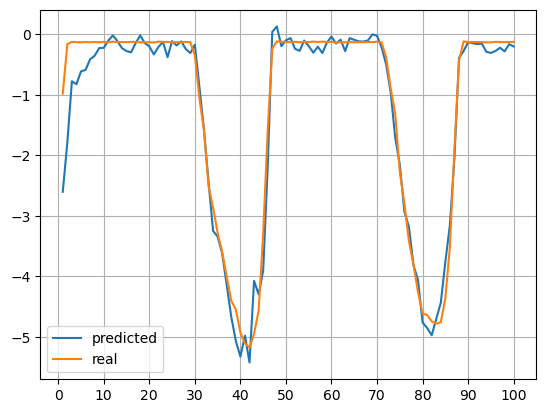

In [10]:
pred_forcess = outputs * forces_z_std + forces_z_mean
forcess = labels.float() * forces_z_std + forces_z_mean
pred_forcess = pred_forcess.detach().numpy()
forcess = forcess.detach().numpy()
plt.plot(range(1,len(pred_forcess)+1), pred_forcess, label = "predicted")
plt.plot(range(1,len(forcess)+1), forcess, label = "real")
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.grid()
plt.legend()
plt.show()

Required: Data collection protocol with buffer start and end times.